In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder

%config InlineBackend.figure_format = 'retina'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Считаем данные

In [2]:
train = pd.read_csv('D:/Datasets/train.csv.zip')
train.head()

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar


In [3]:
test = pd.read_csv('D:/Datasets/test.csv.zip')
test.head()

,index,sentence
0,0,תודה לכם .
1,1,"Precisamos de compaixão para começar , e auto-..."
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .
4,4,これをロボットに組み込みました


In [4]:
test_id = test['index']
test.drop('index', axis=1, inplace=True)

Почистим текст

Удалим XML теги

In [5]:
import re
def preprocessor(text):
    """remove HTML-code and non char symbols"""
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('[\W]+', ' ', text.lower())
    return text

def remove_numbers(text):
    """remove numbers"""
    num=re.compile(r'\d+')
    return num.sub(r'', text)

def remove_xml(text):
    text = re.sub(r'<[^<]+?>', '', text)
    return text

def remove_newlines(text):
    return text.replace('\n', ' ') 
    
def remove_manyspaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text

In [6]:
train['sentence'] = train['sentence'].apply(lambda x: preprocessor(x))
train['sentence'] = train['sentence'].apply(lambda x: remove_numbers(x))
train['sentence'] = train['sentence'].apply(lambda x: remove_xml(x))
train['sentence'] = train['sentence'].apply(lambda x: remove_newlines(x))
train['sentence'] = train['sentence'].apply(lambda x: remove_manyspaces(x))

test['sentence'] = test['sentence'].apply(lambda x: preprocessor(x))
test['sentence'] = test['sentence'].apply(lambda x: remove_numbers(x))
test['sentence'] = test['sentence'].apply(lambda x: remove_xml(x))
test['sentence'] = test['sentence'].apply(lambda x: remove_newlines(x))
test['sentence'] = test['sentence'].apply(lambda x: remove_manyspaces(x))

Удалим пробелы с обоих концов предложений

In [7]:
train['sentence'] = train['sentence'].apply(lambda x : x.strip())
test['sentence'] = test['sentence'].apply(lambda x : x.strip())

Удалим дупликаты

In [8]:
train.shape

(3159633, 2)

In [9]:
train.drop_duplicates('sentence', inplace=True, keep=False)

In [10]:
train.shape

(2725629, 2)

In [11]:
indexes_to_drop = train[(train['sentence'].str.len() < 5)].index
train.drop(indexes_to_drop, axis=0, inplace=True)

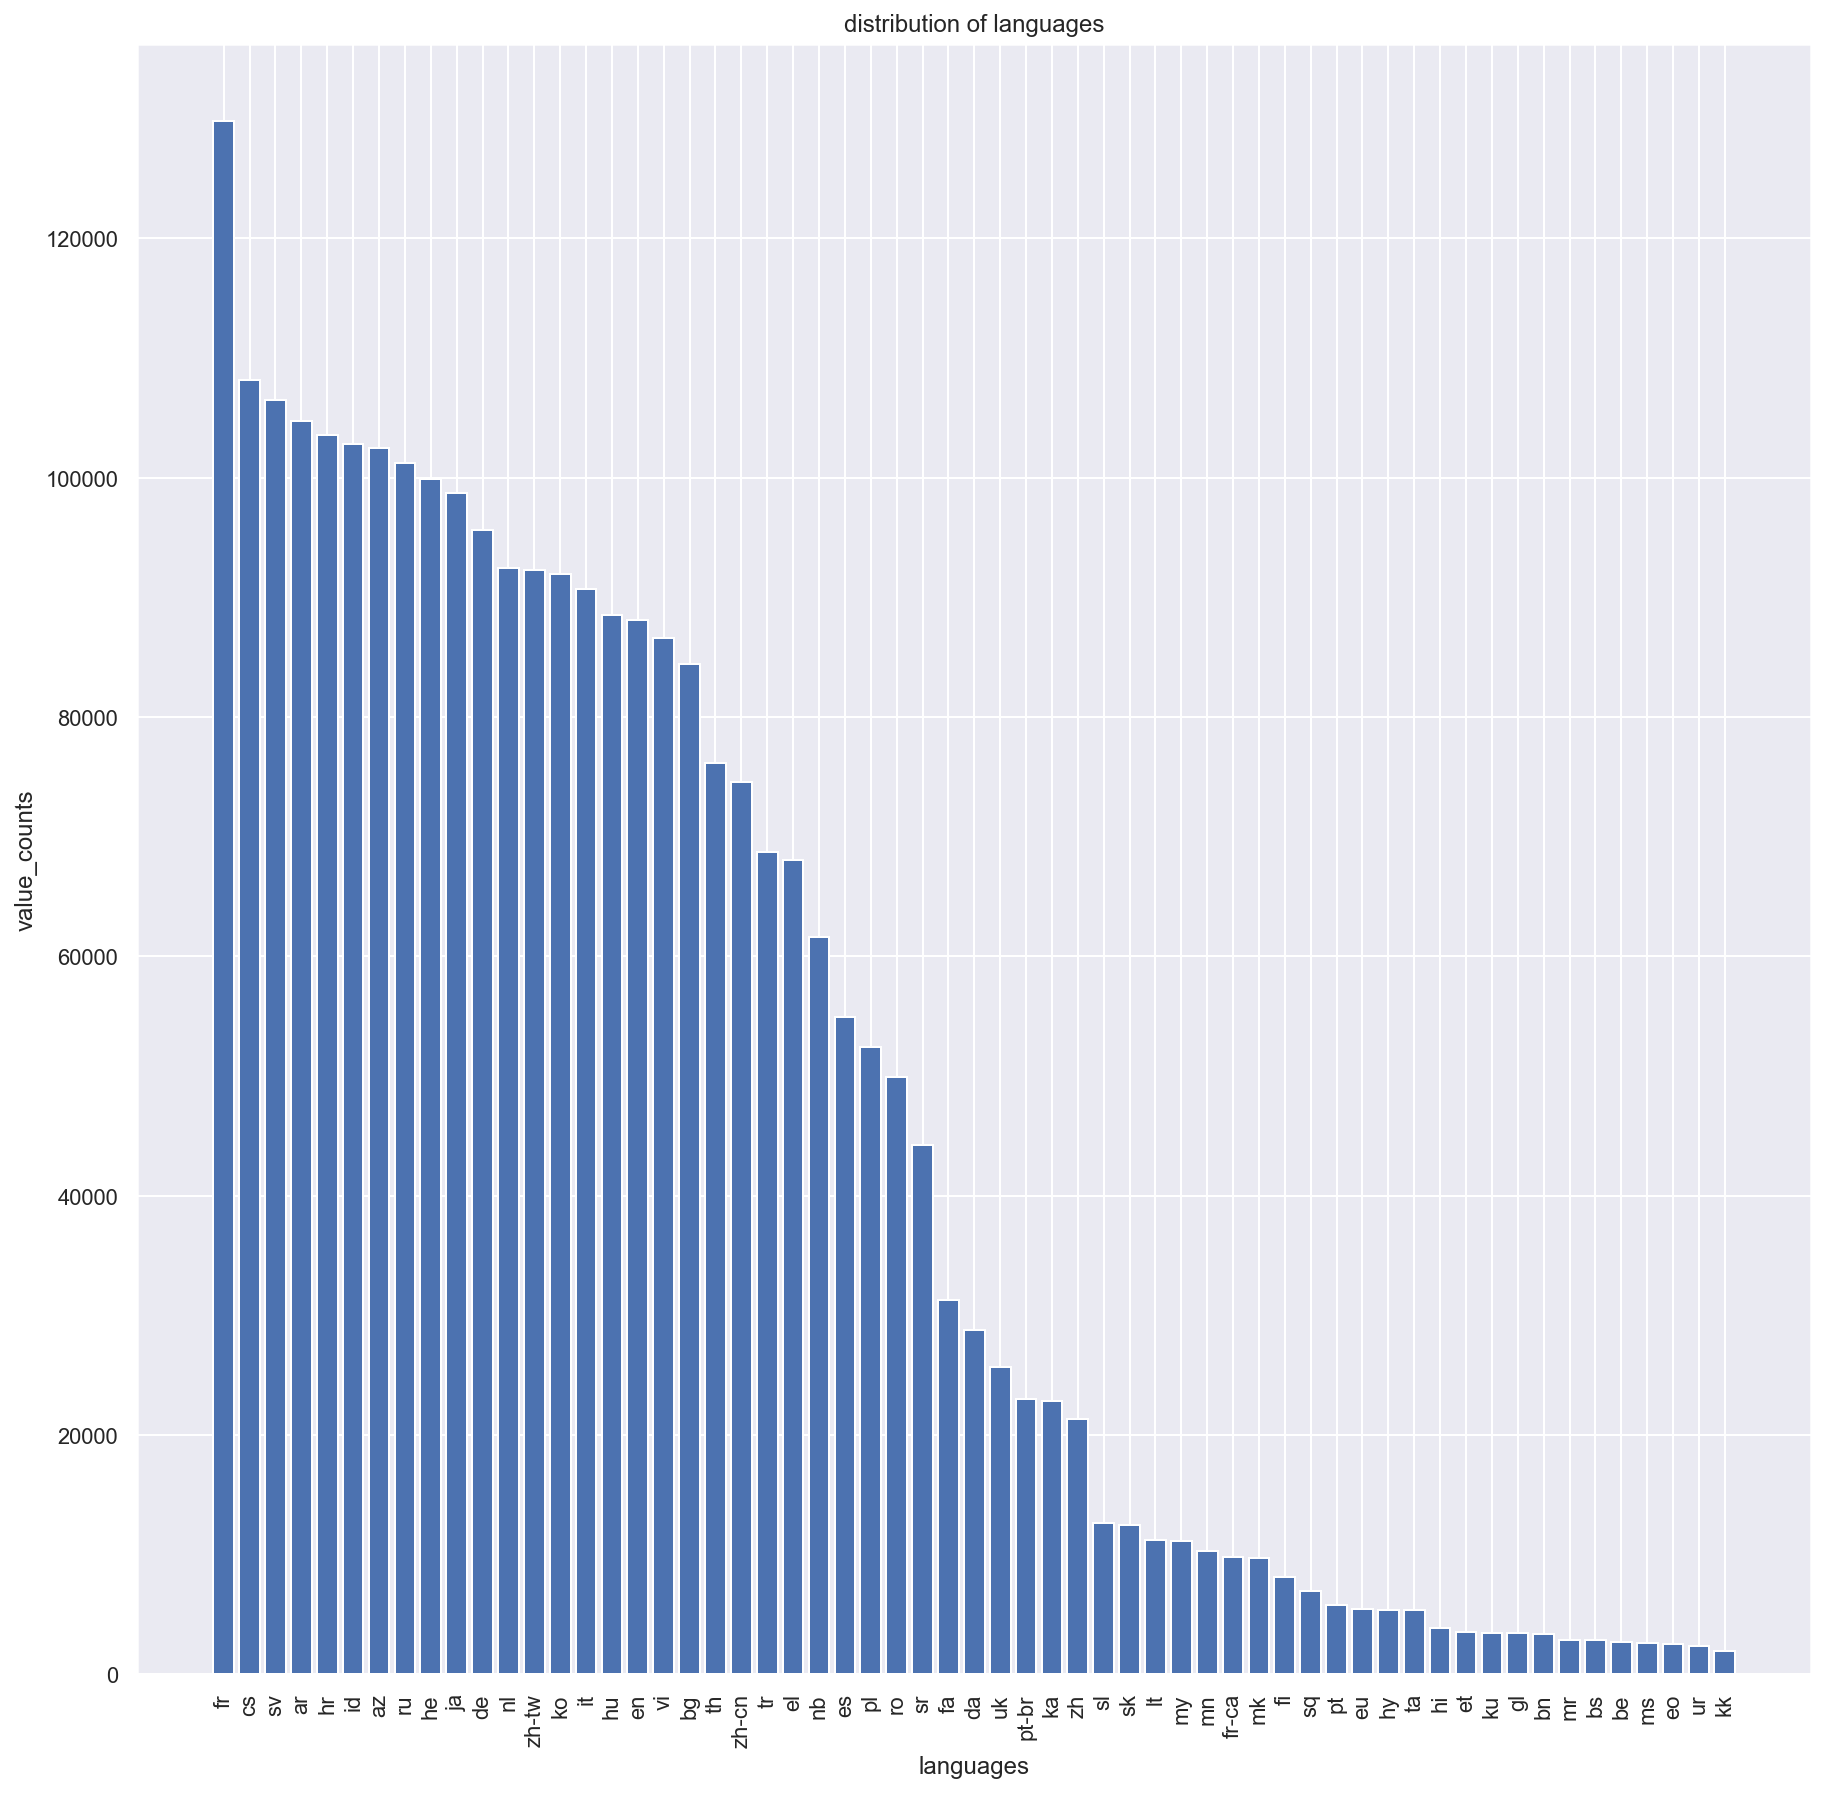

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})


height = train['language'].value_counts()
plt.bar(train['language'].unique(), height)
plt.xticks(rotation='90')
plt.title('distribution of languages')
plt.xlabel('languages')
plt.ylabel('value_counts');

In [13]:
train.shape

(2722834, 2)

In [14]:
y = train['language'].copy()
train.drop(['language'], axis=1, inplace=True)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.1, random_state=13)

VowpalWabbit

In [17]:
#%%capture
#!git clone --recursive https://github.com/VowpalWabbit/vowpal_wabbit.git 
#!cd vowpal_wabbit/; make 
#!cd vowpal_wabbit/; make install 

In [18]:
#all_documents = train['sentence']
#topic_encoder = LabelEncoder()
#all_targets = topic_encoder.fit_transform(y) + 1

In [19]:
#test_vw = test['sentence']

In [20]:
#train_doc, test_doc, train_lab, test_lab = train_test_split(all_documents, all_targets, test_size=0.2)

In [21]:
#def to_vw_format(document, label=None):
#    return str(label or '') + ' |text ' + ' '.join(document) + '\n'

In [22]:
#with open(os.path.join('lan_train.vw'), 'w') as vw_train_data:
#    for text, target in zip(train_doc, train_lab):
#        vw_train_data.write(to_vw_format(text, target))
#with open(os.path.join('lan_test.vw'), 'w') as vw_test_data:
#    for text, target in zip(test_doc, test_lab):
#        vw_test_data.write(to_vw_format(text, target))

Попытка оптимизировать гиперпараметры

In [23]:
#!vowpal_wabbit/utl/vw-hypersearch -L 1e-8 1e-1 vw  --l2 %  lan_train.vw --power_t=0.26195 --l1=1.0014e-08 --l2=1.0014e-08 --ngram 3

In [24]:
#%%time
#!vw --oaa 59 lan_train.vw --ngram 4 -f lang_model_mult.vw --loss_function=logistic --power_t=0.26195

In [25]:
#!vw -i lang_model_mult.vw --loss_function=logistic --power_t=0.26195 -t -d lan_test.vw \
#-p lan_test_predictions.txt

In [26]:
#with open('lan_test_predictions.txt') as pred_file:
#    test_prediction = [float(label) for label in pred_file.readlines()]

In [27]:
#balanced_accuracy_score(test_lab, test_prediction)

fit full_data

train

In [28]:
#with open(os.path.join('lan_train.vw'), 'w') as vw_train_data:
#    for text, target in zip(all_documents, all_targets):
#        vw_train_data.write(to_vw_format(text, target))

In [29]:
#%%time
#!vw --oaa 59 lan_train.vw --ngram 4 -f lang_model_mult.vw --loss_function=logistic --power_t=0.26195

predict

In [30]:
#with open(os.path.join('lan_test.vw'), 'w') as vw_test_data:
#    for text in test_vw:
#        vw_test_data.write(to_vw_format(text))

In [31]:
#!vw -i lang_model_mult.vw --ngram 4 --loss_function=logistic --power_t=0.26195 -t lan_test.vw \
#-p lan_predictions.txt

In [32]:
#with open('lan_predictions.txt') as pred_file:
#    test_prediction = [int(label)-1 for label in pred_file.readlines()]

In [33]:
#y_pred = topic_encoder.inverse_transform(test_prediction)

In [34]:
#submission = pd.DataFrame()
#submission['index'] = test_id
#submission['language'] = y_pred
#submission.to_csv('Naive_Bayes.csv',index=False)

In [35]:
#cnt = HashingVectorizer(analyzer='char_wb', ngram_range=(2,3), norm='l2')

#pipeline_Naive = Pipeline([
#   ('vectorizer',cnt),  
#   ('model',MultinomialNB())
#])

In [36]:
ctf = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,3))

NaiveBayes

In [37]:
#pipeline_Naive.fit(X_train.values.ravel(),y_train.values)
#y_pred = pipeline_Naive.predict(X_test.values.ravel())
#balanced_accuracy_score(y_test, y_pred)

In [38]:
#pipeline_Naive.fit(train.values.ravel(),y.values)
#y_pred_Naive = pipeline_Naive.predict(test.values.ravel())

SGDClassifier

In [39]:
#pipeline_SGD = Pipeline([
#   ('vectorizer',ctf),  
#   ('model',SGDClassifier(loss='log'))
#])

In [40]:
#pipeline_SGD.fit(X_train.values.ravel(),y_train.values)
#y_pred = pipeline_SGD.predict(X_test.values.ravel())
#balanced_accuracy_score(y_test, y_pred)

In [41]:
#pipeline_SGD.fit(train.values.ravel(),y.values)
#y_pred_SGD = pipeline_SGD.predict(test.values.ravel())

SVM

In [42]:
pipeline_SVC = Pipeline([
   ('vectorizer',ctf),  
   ('model',LinearSVC(C=12))
])

In [43]:
#pipeline_SVC.get_params()

In [44]:
#pipeline_SVC.fit(X_train.values.ravel(),y_train.values)
#y_pred = pipeline_SVC.predict(X_test.values.ravel())
#balanced_accuracy_score(y_test, y_pred)

0.9226605110728452

In [ ]:
pipeline_SVC.fit(train.values.ravel(),y.values)
y_pred_SVC = pipeline_SVC.predict(test.values.ravel())

Logistic regression

In [45]:
#pipeline_logreg = Pipeline([
#   ('vectorizer',ctf),  
#   ('model', LogisticRegression(solver='saga'))
#])

In [ ]:
#pipeline_logreg.fit(X_train.values.ravel(),y_train.values)
#y_pred = pipeline_logreg.predict(X_test.values.ravel())
#balanced_accuracy_score(y_test, y_pred)

In [ ]:
#y_naive_enc = topic_encoder.transform(y_pred_Naive)
#y_sgd_enc = topic_encoder.transform(y_pred_SGD)
#pred = np.asarray([y_naive_enc, y_sgd_enc, test_prediction]).T
#vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=pred)
#y_pred = topic_encoder.inverse_transform(vote)

In [51]:
submission = pd.DataFrame()
submission['index'] = test_id
submission['language'] = y_pred_SVC
submission.to_csv('Naive_Bayes.csv',index=False)